 # Discriminative Autoencoder

## Getting Ready

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import skimage.io as skio

import torch as to
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
def secondval( value ):
    
    return value[0]

## Dataset class

In [3]:
class MNIST(nn.Module):
    
    def __init__(self):
        
        super(MNIST,self).__init__()
        
        data = list()
        
        img = pd.read_csv("../data/trainMNIST.csv")
        img = img.values
        img = np.reshape(img, (-1, 28, 28))
        label = pd.read_csv("../data/trainMNISTlabels.csv").values
        
        # Here we create a dictionary of images such that there are 10 keys 
        # each key is a class of the MNIST i.e. number b/w 0 & 9
        # each key returns a list of all the images that is labelled after it
        
        # we first sort the data
        
        for i in range(len(img)):
            
            data.append( [ label[i], img[i] ] )
        
        data.sort(key = secondval)
        
        self.len = len(img)
        
        self.Data = {}

        # here we create the dictionary as said above
        
        for i in data:
            
            if i[0][0] not in self.Data :
                self.Data[i[0][0]] = list()
                self.Data[i[0][0]].append(i[1])
            
            else :
                self.Data[i[0][0]].append(i[1])
        
        for i in self.Data.keys() :
            print( "# of ",i,"'s images : ", len(self.Data[i]) )
        
        return
    
        
    def __getitem__(self,inx):
        
        cl1,cl2 = np.random.randint(0,high=10,size=2)
        
        while cl2 == cl1 :
            cl2 = np.random.randint(0,high=10)
            
        #print("selected classes : ", cl1, cl2)
        
        cl1Len = len(self.Data[cl1])
        cl2Len = len(self.Data[cl2])
        
        ancinx,posinx = np.random.randint(0,high=cl1Len,size=2)
        neginx = np.random.randint(0,high=cl2Len)
        
        #print("selected indices : ", ancinx, ", ", posinx, ", ", neginx)
        
        ancimg = self.Data[cl1][ancinx]
        posimg = self.Data[cl1][posinx]
        negimg = self.Data[cl2][neginx]
        
        ancimg = np.reshape(ancimg,(1,28,28))
        posimg = np.reshape(posimg,(1,28,28))
        negimg = np.reshape(negimg,(1,28,28))
        
        ancimg = to.tensor( ancimg, dtype=to.float, device="cuda")
        posimg = to.tensor( posimg, dtype=to.float, device="cuda")
        negimg = to.tensor( negimg, dtype=to.float, device="cuda")
       
        l1 = to.tensor(np.zeros(1,dtype=np.float32),dtype=to.float32)
        l2 = to.tensor(np.ones(1,dtype=np.float32),dtype=to.float32)
        
        return ancimg, posimg, negimg, l1, l2
    
    
    def __len__(self):
        
        return 5000
        
data = MNIST()        

# of  0 's images :  5923
# of  1 's images :  6742
# of  2 's images :  5958
# of  3 's images :  6131
# of  4 's images :  5842
# of  5 's images :  5420
# of  6 's images :  5918
# of  7 's images :  6265
# of  8 's images :  5851
# of  9 's images :  5949


### Sample View

In [4]:
sample_loader = DataLoader(data)
iterator = iter(sample_loader)
im1, im2, im3, l1, l2 = iterator.next()
im1 = im1.cpu().numpy()
im2 = im2.cpu().numpy()
im3 = im3.cpu().numpy()

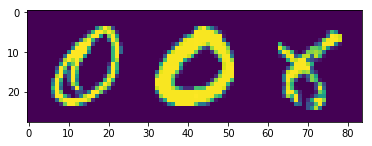

In [5]:
image = np.concatenate( (im1[0][0],im2[0][0],im3[0][0]), axis=1)
plt.imshow(image)

## Model Definition

In [6]:
class Model(nn.Module):
    
    def __init__(self):
        
        super(Model,self).__init__()
            
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)
        
        self.lin1 = nn.Linear(800, 64)
        self.lin2 = nn.Linear(64, 32)
        self.lin3 = nn.Linear(32, 2)
        
        return
        
        
    def encoder(self,inp):
        
        out = self.conv1(inp)
        out = F.relu(out)
        out, self.inx1 = self.pool(out)
        
        
        out = self.conv2(out)
        out = F.relu(out)
        out, self.inx2 = self.pool(out)           
        
        
        return out
        
               
    def decoder(self,inp):
        
        self.copy1 = to.tensor(self.conv1.weight, requires_grad=False)
        self.copy2 = to.tensor(self.conv2.weight, requires_grad=False)
        
        out = F.max_unpool2d(inp, self.inx2, kernel_size=2, stride=2)
        out = F.conv_transpose2d(out, self.copy2 )
        out = F.relu(out)
                
        out = F.max_unpool2d(out, self.inx1, kernel_size=2, stride=2)
        out = F.conv_transpose2d(out, self.copy1 )
        
        out = F.tanh(out)
        
        return out
        
    def siamese(self,inp):
        
        out = inp.view(-1,800)
        
        out = nn.functional.relu(self.lin1(out))
        out = nn.functional.relu(self.lin2(out))
        out = self.lin3(out)
        
        return out
    
    
    def forward(self, anc, pos, neg):
        
        anc_emb = self.encoder(anc)
        anc_out = self.decoder(anc_emb)
        anc_sim = self.siamese(anc_emb)
        
        pos_emb = self.encoder(pos)
        pos_sim = self.siamese(pos_emb)
        
        neg_emb = self.encoder(neg)
        neg_sim = self.siamese(neg_emb)
        
        return anc_out, anc_sim, pos_sim, neg_sim
    
    
    def evaluate(self,inp):
        
        chk = to.tensor([1],dtype=to.float32)
        
        if type(inp) != type(chk):
            
            # inp = np.transpose(inp, (2,1,0) ) #for images
            inp = to.tensor(inp, dtype=to.float32, device=device)
            
        out = forward(inp)
        
        return out

## Loss functions and Train time params

In [7]:
class ContrastiveLoss(nn.Module):
 
    def __init__(self, margin=10.0):
        super(Loss, self).__init__()
        self.margin = margin

    def forward(self, x, y, label):
        
        x = x.cpu()
        y = y.cpu()
        
        euclidean_distance = nn.functional.pairwise_distance(x,y)
        
        loss_contrastive = to.mean((1-label) * to.pow(euclidean_distance, 2) +
                                      (label) * to.pow(to.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive
    

In [8]:
dataloader = DataLoader(data, batch_size=64)
model = Model().cuda()

In [9]:
number_epochs = 100
Criterion1 = nn.MSELoss()
Criterion2 = ContrastiveLoss()
Optimizer = to.optim.Adam( model.parameters(), lr = 0.001 )

## Training Begins

In [10]:
counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0,number_epochs):
    for data in dataloader:
   
        anc, pos, neg, l1, l2 = data
    
        Optimizer.zero_grad()
        
        # here we obtain the positive pairs' loss as well as the negative pairs' loss
        
        anc_out, anc_sim, pos_sim, neg_sim = model(anc, pos, neg)
        
        # the total loss is then computed and back propagated
        
        loss = Criterion1(anc.cpu(), anc_out.cpu()) + 100*Criterion2(anc_sim, pos_sim, l1) + 100*Criterion2(anc_sim, neg_sim, l2)
        
        loss.backward()
        
        Optimizer.step()
    
    # printing the training errors
    
    print("Epoch number {}\n  Current loss {}\n".format(epoch,loss.item()))
    counter.append(epoch+100)
    loss_history.append(loss.item())

/home/rishi/.conda/envs/DL/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/rishi/.conda/envs/DL/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/rishi/.conda/envs/DL/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch number 0
  Current loss 8268.3994140625

Epoch number 1
  Current loss 7445.9267578125

Epoch number 2
  Current loss 9423.4375

Epoch number 3
  Current loss 10502.7666015625

Epoch number 4
  Current loss 9497.2705078125

Epoch number 5
  Current loss 7688.123046875

Epoch number 6
  Current loss 7741.5751953125

Epoch number 7
  Current loss 9578.921875

Epoch number 8
  Current loss 8752.7412109375

Epoch number 9
  Current loss 8752.9873046875

Epoch number 10
  Current loss 9259.998046875

Epoch number 11
  Current loss 6996.4912109375

Epoch number 12
  Current loss 7992.189453125

Epoch number 13
  Current loss 9015.98828125

Epoch number 14
  Current loss 7554.54931640625

Epoch number 15
  Current loss 8816.6962890625

Epoch number 16
  Current loss 8333.125

Epoch number 17
  Current loss 8248.5849609375

Epoch number 18
  Current loss 7386.822265625

Epoch number 19
  Current loss 9870.666015625

Epoch number 20
  Current loss 7012.55712890625

Epoch number 21
  Curre

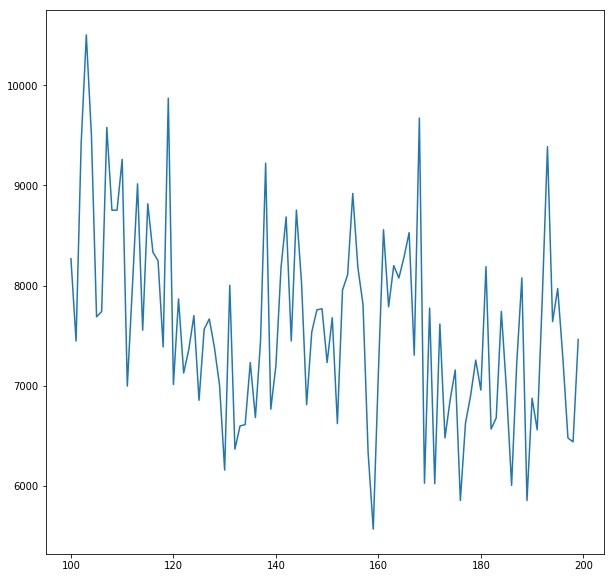

In [21]:
plt.figure(figsize=(10,10))
plt.plot(counter,loss_history)

## Evaluating performance

In [12]:
data = MNIST()
sample_loader = DataLoader(data)
iterator = iter(sample_loader)
im1, im2, im3, l1, l2 = iterator.next()
img1 = im1.cpu().numpy()
img2 = im2.cpu().numpy()
img3 = im3.cpu().numpy()


# of  0 's images :  5923
# of  1 's images :  6742
# of  2 's images :  5958
# of  3 's images :  6131
# of  4 's images :  5842
# of  5 's images :  5420
# of  6 's images :  5918
# of  7 's images :  6265
# of  8 's images :  5851
# of  9 's images :  5949


### Reconstruction

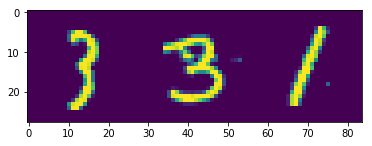

In [13]:
image = np.concatenate( (img1[0][0],img2[0][0],img3[0][0]), axis=1)
plt.imshow(image)

/home/rishi/.conda/envs/DL/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/rishi/.conda/envs/DL/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


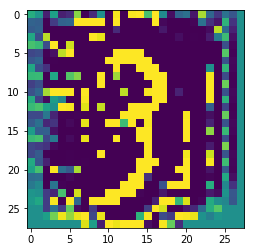

In [14]:
with to.no_grad() :
    anc_out, anc_sim, pos_sim, neg_sim = model(im1, im2, im3)

img = anc_out.cpu().detach().numpy()

plt.imshow(img[0][0])

In [15]:
class Data(Dataset) :
    
    def __init__(self):
        
        super(Data,self).__init__()
        
        self.data = pd.read_csv("../data/trainMNIST.csv").values
        self.label = pd.read_csv("../data/trainMNISTlabels.csv").values
    
    
    def __getitem__(self, inx) :
        
        sample = self.data[inx]
        label = self.label[inx]
        
        img = np.reshape(sample,(1,28,28))
        
        img = to.tensor(img, dtype=to.float32)
        label = to.tensor(label, dtype=to.float32)
        
        return img, label
        
    
    def __len__(self):
        
        return len(self.data)

In [16]:
plot_data = Data()

### Discriminative embedding

In [17]:
plot_loader = DataLoader(plot_data,batch_size=128)

iterator = iter(plot_loader)
data = iterator.next()

points = np.array([[0,0,0]])

for data in plot_loader :   
    img, lb = data
    lb = lb.detach().cpu().numpy()

    with to.no_grad():

        emb = model.encoder(img.cuda())
        point = model.siamese(emb)
        point = point.detach().cpu().numpy()
        point = np.concatenate((point,lb), axis=1)

        points = np.concatenate( (points,point), axis=0 )        
        

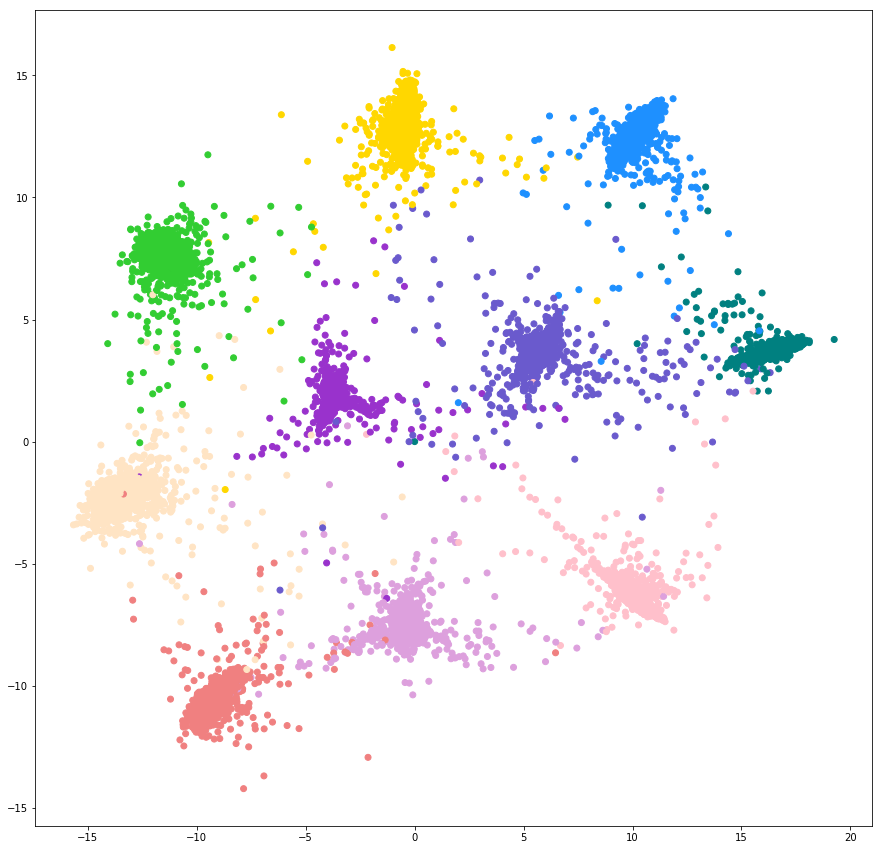

In [23]:
colors = ['teal','limegreen','gold','darkorchid','lightcoral','pink','dodgerblue','bisque','slateblue','plum']
import matplotlib
plt.figure(figsize=(15,15))
plt.scatter(x=points[:,0],y=points[:,1],c=points[:,2], cmap=matplotlib.colors.ListedColormap(colors))

In [19]:
to.save(model.state_dict(),"./discriminative_autoencoder.st")